#  ATLAS/ICESat-2 Monthly Gridded Sea Ice Freeboard
*Introduce dataset here*

In [1]:
#this cell will load dependencies for running the notebook in Google Colab
#this cell may take a while to run
import sys

#if code is running in google colab, run these cells to install neccessary libraries
if 'google.colab' in sys.modules: 
    !apt-get install -qq libgdal-dev libproj-dev
    !pip install --no-binary shapely shapely --force
    !pip install -q pyproj
    !pip install cartopy
    !pip install netcdf4
    !pip install xarray==0.16.0

# Import notebook dependencies

In [2]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
from glob import glob
from textwrap import wrap
from scipy.interpolate import griddata

#axes needed for plotting
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

#remove warnings to improve display
import warnings
warnings.filterwarnings('ignore')

#increase resolution for notebook outputs
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

```{tip}
Try running this notebook in Google Colab! Toggle over the rocketship icon at the top of the page and click Colab to open a new window and run the notebook. <br><br>To run a single cell, type **Shift+Enter**. To run the whole notebook, under **Runtime** click **Run all**. Note that you will have to run the notebook from the very beginning and load all the Google Colab dependencies for the code to work.
```

# Set desired date range 
Our analysis looks at winter data, so we'll only load data for the Northern Hemisphere winter season (Nov-Apr)

In [3]:
def getWinterDateRange(start_year, end_year, start_month = "November", end_month = "April"): 
    """ Gets date range for winter season/s
    Calling the function for start_year=2018, end_year=2020, start_month="November", end_month="April" will generate a date range from Nov 2018-Apr 2019 and Nov 2019-Apr 2020
    
    Args: 
        start_year (str): start year 
        end_year (str): end year 
        start_month (str, optional): month at which winter starts (default to November)
        end_month (str, optional): month at which winter ends (default to April)
        
    Returns: 
        winters (list): list of dates for all winter seasons in the input range (i.e: ['1980-11','1980-12','1981-01',
         '1981-02','1981-03','1981-04')
    """
    start_year = int(start_year)
    end_year = int(end_year)
    
    winters = []
    for year in range(start_year, end_year, 1):
        winters += pd.date_range(start = str(year) + '-' + start_month,
                                 end = str(year + 1) + '-' + end_month,
                                 freq = 'MS')
    winters = pd.to_datetime(winters)
    return winters

In [4]:
start_year = "2018"
end_year = "2020"
winter_months = getWinterDateRange(start_year, end_year)
print(winter_months)

DatetimeIndex(['2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01'],
              dtype='datetime64[ns]', freq=None)


# Read data

In [5]:
def read_is2_data(data_dir="IS2SITMOGR4"): 
    """ Read in ATLAS/ICESat-2 Monthly Gridded Sea Ice Freeboard dataset. 
    If the file does not already exist on the user's local drive, it is downloaded from the books google storage bucket (https://console.cloud.google.com/storage/browser/is2-pso-seaice)
    The netcdf files for each month are then read in as an xr.Dataset object
    
    Args: 
        data_dir (str, optional): name of data directory containing ICESat-2 data (default to "IS2SITMOGR4", the name of the directory in the bucket)
    Returns: 
        is2_ds (xr.Dataset): data 
    
    """
    # Download data from bucket if it doesn't exist on the user's local drive
    exists_locally = os.path.isdir(data_dir)
    if (exists_locally == False): 
        print("Downloading ICESat-2 data from the google storage bucket...")
        os.system("gsutil -m cp -r gs://is2-pso-seaice/" + data_dir + " ./") # Make sure theres a space before the final ./ (i.e. " ./")
        print("Download complete")

    # Read in files for each month as a single xr.Dataset
    # Need to create a preprocessing function to call before merging because dimensions and coordinates are not set
    # This allows each DataArray for each month to be merged into one xr.Dataset
    def xr_set_coords_and_dims(da_monthly):
        da_monthly = da_monthly.set_coords(["latitude","longitude","xgrid","ygrid"]) # Set data variables as coordinates
        da_monthly = da_monthly.expand_dims("time") # Set month as a dimension 
        return da_monthly
    
    filenames = os.listdir(data_dir)
    is2_ds = xr.open_mfdataset([data_dir + "/" + filename for filename in filenames], # Filepath, including data directory in path
                               concat_dim=["time"], 
                               combine='nested', 
                               preprocess=xr_set_coords_and_dims)
    time = [file.split("IS2SITMOGR4_01_")[1].split("_004_001.nc")[0] for file in filenames] # Get time from filenames
    is2_ds = is2_ds.assign_coords({"time":pd.to_datetime(time, format = "%Y%m")}) # Add time as coordinate
    return is2_ds

In [6]:
is2_ds = read_is2_data() # Read in data
is2_ds = is2_ds.sel(time = winter_months) # Get winter months
print(is2_ds)

<xarray.Dataset>
Dimensions:            (time: 12, x: 304, y: 448)
Coordinates:
    longitude          (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
    latitude           (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
    xgrid              (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
    ygrid              (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
  * time               (time) datetime64[ns] 2018-11-01 ... 2020-04-01
Dimensions without coordinates: x, y
Data variables:
    projection         (time) int32 -2147483647 -2147483647 ... -2147483647
    ice_thickness      (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness_unc  (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    num_segments       (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    mean_day_of_month  (time, y, x) float32 dask.array<chunksize=(1, 448, 304

# Set interpolation preferences  
The dataset included uninterpolated data, or we can interpolate the data using a simple nearest neighbor interpolation function. Because ICESat-2 doesn't provide full monthly coverage, interpolating fills missing grid cells with a best guess based on surrounding data. This helps avoid sampling biases when performing time series analyses, with the cavaet that this interpolation method is subjective. <br><br>
In order to definte the interpolation bounds (so that we don't try and interpolate over land, or other areas where there wouldn't be sea ice!), we use the [NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration](https://nsidc.org/data/g02202) dataset to infer the location of the sea ice. A version of this dataset is included in the netcdf file associated with the jupyter book and downloaded in the code cells below. 

In [7]:
interpolate = True 

In [8]:
def read_book_data(filepath = "icesat2-book-data.nc"): 
    """ Read in data for ICESat2 jupyter book. 
    If the file does not already exist on the user's local drive, it is downloaded from the books google storage bucket (https://console.cloud.google.com/storage/browser/is2-pso-seaice)
    The netcdf file is then read in as an xr.Dataset object 
    
    Args: 
        filepath (str, optional): name of file to read in (default to "icesat2-book-data.nc", the name of the file in the bucket)
    Returns: 
        book_ds (xr.Dataset): data 
    
    """
    exists_locally = os.path.isfile(filepath) # Check if file exists on local drive
    if (exists_locally == False): # Download data 
        print("Downloading jupyter book data from the google storage bucket...")
        os.system("gsutil -m cp gs://is2-pso-seaice/" + filepath + " ./") # Make sure theres a space before the final ./ (i.e. " ./")
        print("Download complete")

    book_ds = xr.open_dataset(filepath)
    return book_ds

In [9]:
def is2_interp2d(is2_ds, cdr_da, method="nearest", interp_var="all"): 
    """ Perform 2D interpolation over geographic coordinates for all ICESat-2 sea ice variables with geographic coordinates in xr.Dataset
    As of 06/02/2021, xarray does not have a 2D interpolation function so this function is built on scipy.interpolate.griddata (https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html)
    This function assumes that the dataset has physical coordinates (i.e. lat,lon) as coordinates but logical coordinates (i.e. (x,y)) as dimensions (http://xarray.pydata.org/en/stable/examples/multidimensional-coords.html)
    
    Args: 
        is2_ds (xr.Dataset): ICESat-2 dataset containing variables to interpolate
        cdr_da (xr.DataArray): NSIDC sea ice concentration. Must contain the same time variable as is2_ds
        method (str,optional): interpolation method (default to "linear", choose from {‘linear’, ‘nearest’, ‘cubic’})
        interp_va (srt or list, optional): variables to interpolate (default to "all", variables with geographic coordinates)
    
    Returns: 
        ds_interp (xr.Dataset): dataset with interpolated variables
    
    """
 
    # Get 2d variables in dataset, ensure that user input was valid and raise errors if not
    def get_2d_vars(is2_ds, interp_var): 
        """ Get 2d variables in dataset for interpolation 
        """
        vars_2d = [var for var in is2_ds.data_vars if set(['latitude','longitude']).issubset(list(is2_ds[var].coords))]
        if len(vars_2d) == 0: 
            raise ValueError("The input dataset does not contain geographic coordinates that can be read. See function documentation for more information.")
        if interp_var == "all": 
            interp_var = vars_2d.copy()
        elif (type(interp_var) == str) and (interp_var in vars_2d): 
            interp_var = list(interp_var)
        else:
            raise ValueError("Invalid input for interp_var")
        return interp_var                          
    interp_var_2d = get_2d_vars(is2_ds, interp_var)
    
    # Get geographic coordinates
    lats = is2_ds['latitude'].values
    lons = is2_ds['longitude'].values
    
    # Loop through variables and timesteps and interpolate 
    np_cdr = cdr_da.values
    ds_interp = is2_ds.copy()
    for var in interp_var_2d: 
        var_interp_list = []
        da_var = is2_ds[var]
        for timestep in is2_ds.time.values: 
            da = da_var.sel(time = timestep) 
            np_da = da.values
            np_da = ma.masked_where((np.isnan(np_da)) & (cdr_da.sel(time = timestep).values > 0.15), np_da)
            np_interp = griddata((lons[~np_da.mask], lats[~np_da.mask]), # Interpolate
                                  np_da[~np_da.mask].flatten(),
                                  (lons, lats), 
                                  fill_value=np.nan,
                                  method=method)
            da_interp = xr.DataArray(data=np_interp, # convert numpy array --> xr.DataArray
                                     dims=da.dims, 
                                     coords=da.coords,
                                     attrs={**da.attrs,'interpolation':'interpolated from original variable using ' + method + ' interpolation'},
                                     name=da.name)
            da_interp = da_interp.where(lats < 88, np.nan) # Set pole hole to nan
            da_interp = da_interp.expand_dims("time") # Add time as a dimension. Allows for merging DataArrays 
            var_interp_list.append(da_interp)
        
        var_interp = xr.merge(var_interp_list)
        ds_interp[var] = var_interp[var] # Replace variable with interpolated variable
    
    return ds_interp

In [10]:
if (interpolate == True): 
    cdr_da = read_book_data()["seaice_conc_monthly_cdr"] # Get CDR data
    cdr_da = cdr_da.sel(time = winter_months) # Get winter months
    is2_ds = is2_interp2d(is2_ds, cdr_da, method='nearest', interp_var='all')

# Plot mean winter ice thickness
Using the cartopy mapping package for python, we overlay mean ice thickness for each winter season on a basemap of the Arctic.

In [11]:
thickness = is2_ds['ice_thickness']

In [12]:
def plotArcticMap(da, minval = 0, maxval = 1, title = None, cbarTicks = None, cmap = 'viridis', show_mean = True, figPath = None): 
    """Plots map of the arctic on North Pole Stereo projection with one month of data overlayed, along with the sea ice edge for each month.
    Cartopy has a bug and cannot produce a contour plot on a rotated grid. Here we use a workaround from stackexchange: https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
   
    Args:
        da (xr DataArray): data to plot
        minval, maxval (int): minimum and maximum values for the data variable 
        cbarTicks (list or np array of length 2): ticks to use on colorbar (default to [minval + 1, maxval +1])
        cmap (str, optional): color map (default to viridis)
        title (str, optional): title of subplots (default to name of variable)
        show_mean (bool, optional): add mean value to plot (default to True)
        figPath (str, optional): path to save fig (default to None)
        
    Returns:
        Figure displayed in notebook 
    
    """

    #initialize the figure and axes 
    proj = ccrs.NorthPolarStereo(central_longitude = -45)
    transform = ccrs.PlateCarree()
    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection = proj)
    
    # colorbar settings
    cbarTicks = np.arange(minval, maxval + 1, 1) if cbarTicks is None else cbarTicks
    cbar_label = "" #create colorbar label using variable name and units if available as attributes
    attrs = da.attrs
    if 'long_name' in attrs:
        cbar_label += attrs['long_name'] + " "
    if 'units' in attrs:
        cbar_label += "(" + attrs['units'] + ")"
    elif 'unit' in attrs: 
        cbar_label += "(" + attrs['unit'] + ")"

    #plot the data
    da.plot(x = 'longitude', y = 'latitude', vmin = minval, vmax = maxval, extend = 'both', 
                        ax = ax, add_colorbar = True, transform = transform, zorder = 2, cmap = cmap, 
                        cbar_kwargs = {'label': "\n".join(wrap(cbar_label, 50)), 'orientation': 'horizontal', 'shrink': 0.75, 'pad': 0.025})
    
    #add features to the map
    ax.coastlines(linewidth=0.15, color = 'black', zorder = 10) #add coastlines 
    ax.add_feature(cfeature.LAND, color ='0.95', zorder = 5) #add land 
    ax.add_feature(cfeature.LAKES, color = 'grey', zorder = 5) #add lakes 
    ax.gridlines(draw_labels = False, linewidth = 0.25, color = 'gray', alpha = 0.7, linestyle = '--', zorder = 6) #add gridlines
    ax.set_extent([-179, 179, 55, 90], crs = transform) #zoom in so map only displays the Arctic
    
    if title != None: #add title
        ax.set_title("\n".join(wrap(title, 40)), fontsize = 13, y = 1, fontweight = 'medium')
    
    if show_mean: #add mean value 
        mean_val = round(da.mean().values.item(),2)
        ax.text(x = 0.68, y = 0.97, s = "mean val: " + str(mean_val), zorder = 20, horizontalalignment = 'left', verticalalignment = 'top', fontsize = 10, transform = ax.transAxes, bbox = {'facecolor':'white', 'edgecolor':'lightgrey', 'boxstyle':'round'})
    
    if figPath != None: # save and display figure
        plt.savefig(figPath, dpi = 200)
    plt.show()

## Winter 2018-19

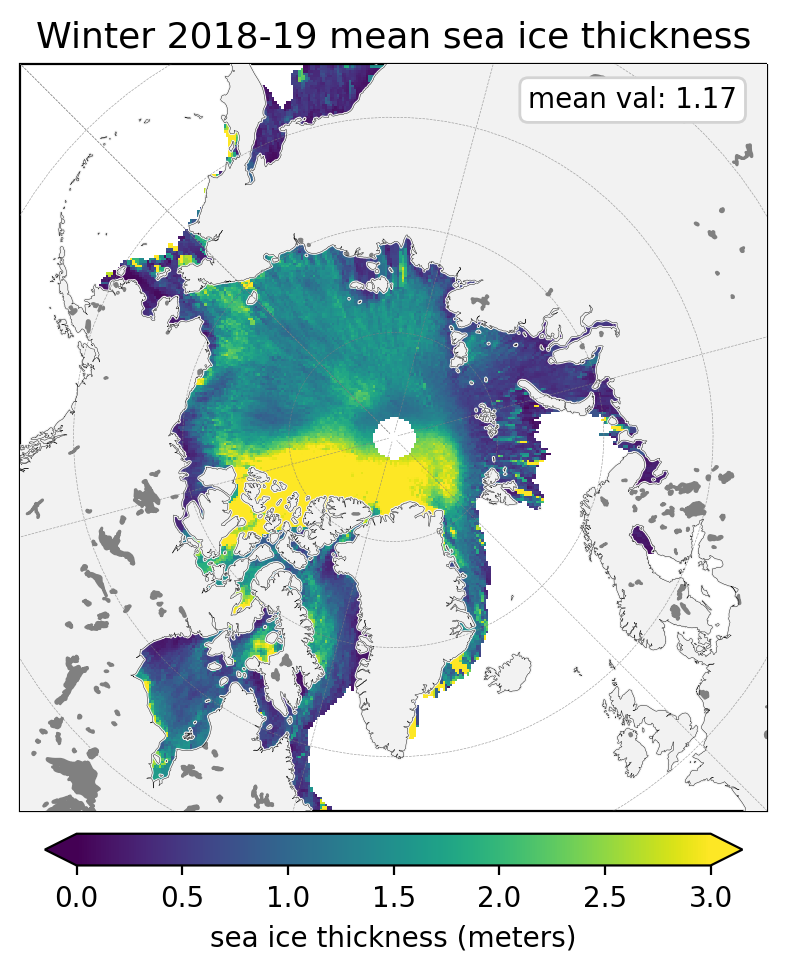

In [13]:
# Compute mean thickness for winter 1 (Nov 2018 - Apr 2019)
thickness_av_winter1 = thickness.sel(time=slice("Nov 2018", "Apr 2019")).mean(dim = ["time"])
thickness_av_winter1 = thickness_av_winter1.assign_attrs(thickness.attrs)

# Plot
plotArcticMap(thickness_av_winter1, minval=0, maxval=3, title="Winter 2018-19 mean sea ice thickness")

## Winter 2019-20

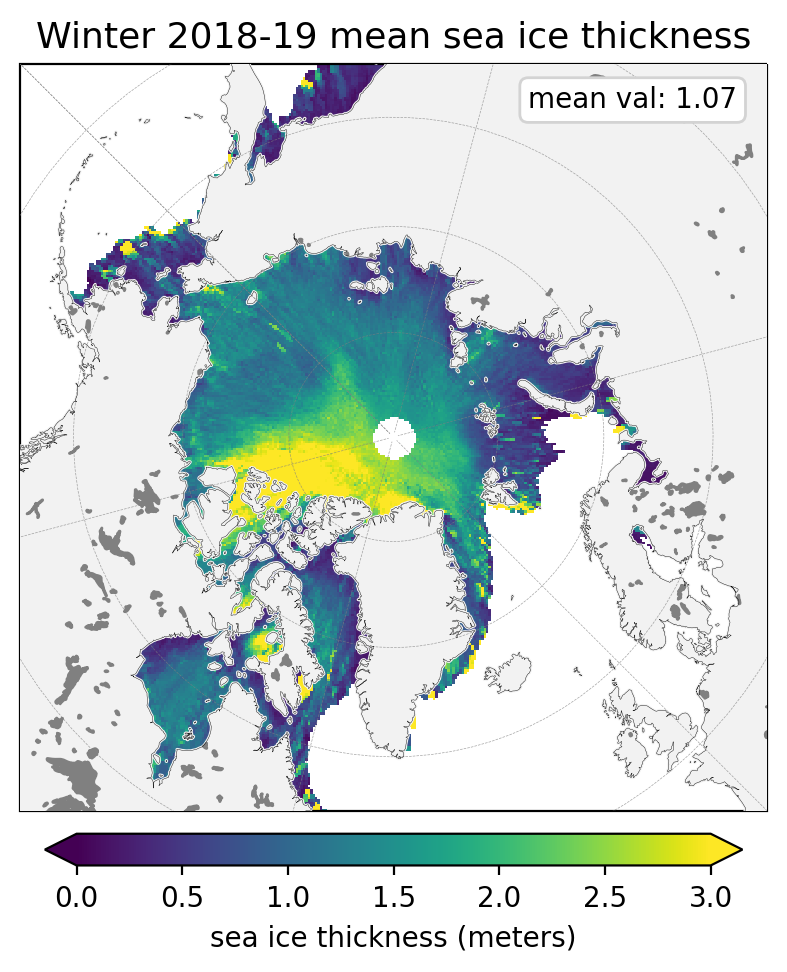

In [14]:
# Compute mean thickness for winter 2 (Nov 2019 - Apr 2020)
thickness_av_winter2 = thickness.sel(time=slice("Nov 2019", "Apr 2020")).mean(dim = ["time"])
thickness_av_winter2 = thickness_av_winter2.assign_attrs(thickness.attrs)

# Plot
plotArcticMap(thickness_av_winter2, minval=0, maxval=3, title="Winter 2018-19 mean sea ice thickness")